# Advanced DL and RL: Домашнее задание 1

Николай Горев

MADE-DS-32

In [1]:
import gym
from gym.envs import toy_text

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Часть первая, с блекджеком и стратегиями

**1.** Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [2]:
env = gym.make('Blackjack-v0')

In [3]:
def simpliest_strategy(sum_hand):
    return sum_hand not in [19, 20, 21]

In [4]:
def one_round():
    env.reset()
    sum_hand = 0
    done = False
    while not done:
        action = simpliest_strategy(sum_hand)
        observation, reward, done, info = env.step(action)
        sum_hand = observation[0]
    env.close()
    return reward

In [5]:
num_experiments = 100000
total_reward = 0
for _ in range(num_experiments):
    total_reward += one_round()

print("\nСредний выигрыш: %.6f" % (total_reward / num_experiments))


Средний выигрыш: -0.436510


**2.** Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [6]:
class QLearningAgent:
    def __init__(self, alpha, max_epsilon, gamma, environment, test_rounds=100000):

        self.environment = environment
        self.Qvalues = {}
        self.n_actions = environment.action_space.n
        self.alpha = alpha
        self.max_epsilon = max_epsilon
        self.epsilon = max_epsilon
        self.gamma = gamma
        self.test_rounds = test_rounds
        
    def get_Qs(self, state):
        if state not in self.Qvalues:
            self.Qvalues[state] = np.random.random(self.n_actions) * 2 - 1.
        return self.Qvalues[state]

    def get_V(self, state):
        return np.max(self.get_Qs(state))

    # Q(s,a) := Q(s,a) + alpha * (r + gamma * V(s') - Q(s,a))
    def update(self, state, action, reward, next_state):
        Q = self.get_Qs(state)[action]
        if reward == 0:
            V = self.get_V(next_state)
        else:
            V = 0
        self.Qvalues[state][action] = Q + self.alpha * (reward + self.gamma * V - Q)

    def get_best_action(self, state):
        return np.argmax(self.get_Qs(state))

    # epsilon-greedy action
    def get_action(self, state):
        if np.random.random() > self.epsilon:
              return self.get_best_action(state)
        else:
              return random.choice(range(self.n_actions))
            
    def test_performance(self):
        total_reward = 0
        for _ in range(self.test_rounds):
            s = self.environment.reset()
            done = False
            while not done:
                action = self.get_best_action(s)
                s, reward, done, info = self.environment.step(action)
            total_reward += reward
        return total_reward / self.test_rounds
    
    def train(self, t_max=1000000, perf_interval=100000):
        performances = []
        for t in range(t_max):
            # изменяем параметр epsilon для epsilon-greedy action 
            # в начале обучения высокий exploration, в конце - низкий
            self.epsilon = self.max_epsilon * (t_max - t) / t_max
            
            if t % perf_interval == 0:
                performances.append((t, self.test_performance()))
            s = self.environment.reset()
            done = False
            while not done:
                action = self.get_action(s)
                next_s, reward, done, info = self.environment.step(action)
                self.update(s, action, reward, next_s)
                s = next_s
        return performances

In [7]:
agent = QLearningAgent(alpha=0.01, max_epsilon=0.5, gamma=1, environment=gym.make('Blackjack-v0', natural=True))

In [8]:
results = agent.train()

**3.** Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [9]:
def plot_results(results):
    steps, rewards = [x[0] for x in results], [x[1] for x in results]
    plt.plot(steps, rewards)
    plt.grid()
    plt.xlabel("Шаг обучения")
    plt.ylabel("Средний доход на одну игру")
    plt.title("Среднее по трем последним значениям {}".format(np.mean(rewards[-3])))
    plt.ylim(-0.5, 0.1)

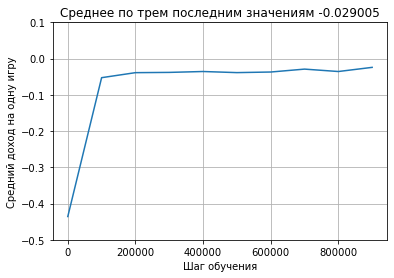

In [10]:
plot_results(results)

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

**4.** Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.


In [11]:
class BlackJackWithDoubling(toy_text.BlackjackEnv):
    def __init__(self, natural=False):
        super().__init__(natural)
        self.action_space = gym.spaces.Discrete(3)
        
    def step(self, action):
        if action == 2:
            s, reward, done, info = super().step(1)
            if done:
                return s, reward * 2, done, info
            s, reward, done, info = super().step(0)
            return s, reward * 2, done, info
        return super().step(action)        

**5.** Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [12]:
agent2 = QLearningAgent(alpha=0.01, max_epsilon=0.5, gamma=1, environment=BlackJackWithDoubling(natural=True))
results = agent2.train()

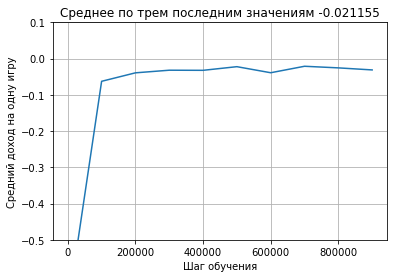

In [13]:
plot_results(results)

## Часть третья
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

**6.** Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).


Будем использовать систему подсчёта [«Плюс-минус»](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA).

Каждой карте, выходящей из колоды, присваивается своё числовое значение:

| Карты          | Числовые значения |
|:-------------- |:-----------------:|
| 2, 3, 4, 5, 6  |         +1        |
| 7, 8, 9        |          0        |
| 10, В, Д, К, Т |         -1        |



In [14]:
# Веса для подсчета карт по системе плюс-минус
cardWeight = {1: -1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: -1}

def cmp(a, b):
    return float(a > b) - float(a < b)

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackJackWithCounting(gym.Env):
    def __init__(self, natural=False):
        self.action_space = gym.spaces.Discrete(3)
        self.seed()
        
        self.natural = natural
        
        self.deck = []
        self.cardsCounter = 0
        

        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    
    # Восстановление полной колоды
    def reset_deck(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                     1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                     1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                     1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

    def draw_card(self, np_random):
        # выбираем случайную карту и удаляем ее из колоды
        index = np_random.choice(range(len(self.deck)))
        return int(self.deck.pop(index))

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: #double
            s, reward, done, _ = self.step(1)
            if not done:
                s, reward, done, _ = self.step(0)
            reward *= 2
        elif action == 1:  # hit: add a card to players hand and return
            card = self.draw_card(self.np_random)
            self.cardsCounter += cardWeight[card] 
            self.player.append(card)
            if is_bust(self.player):
                done = True
                reward = -1.
                self.cardsCounter += cardWeight[self.dealer[1]] 
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
            # предполагаем, что в конце игры дилер открывает все свои карты
            for card in self.dealer[1:]:
                self.cardsCounter += cardWeight[card] 
                
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.cardsCounter)

    def reset(self):
        # если в колоде осталось меньше 15 карт, 
        # восстанавливаем колоду и сбрасываем счетчик карт
        if len(self.deck) < 15:
            self.reset_deck()
            self.cardsCounter = 0
            
        self.dealer = self.draw_hand(self.np_random)
        
        # в начале игры дилер открывает только одну карту
        self.cardsCounter += cardWeight[self.dealer[0]] 

        self.player = self.draw_hand(self.np_random)
        
        self.cardsCounter += cardWeight[self.player[0]] 
        self.cardsCounter += cardWeight[self.player[1]] 
        
        return self._get_obs()

**7.** Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [15]:
env = BlackJackWithCounting(natural=True)
agent3 = QLearningAgent(alpha=0.001, max_epsilon=0.5, gamma=1, environment=env, test_rounds=1000000)

Чтобы ускорить обучение, скопируем значения функции Q из предыдущей задачи. Затем будем дообучать с использованием подсчета карт в колоде.

В окружении BlackJackWithCounting - первые три элемента состояния среды совпадают с предыдущей задачей, а последний элемент - целое число в интервале -20...20 - равно текущему значению оценки разыгранных карт.

In [16]:
# s - состояние среды из предыдущей задачи
for s, Q in agent2.Qvalues.items():
    for i in range(-20, 21):
        s_new = s + (i,) # s_new - состояние среды новой задачи
        agent3.Qvalues[s_new] = Q[:]

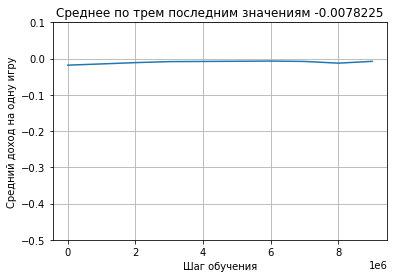

In [17]:
results = agent3.train(t_max=10000000, perf_interval=1000000)
plot_results(results)

**Заключение**

Несмотря на все предпринятые ухищрения, победить казино не удалось.